In [43]:
import numpy as np
from scipy import signal
from scipy.integrate import solve_ivp
from sympy import *
import matplotlib.pyplot as plt
import eom2js

def disp(name: str, symbol: Symbol):
    display(Eq(Dummy(name), symbol, evaluate=False))

def mateq2list(lhs: Matrix, rhs: Matrix):
    L = []
    for i in range(lhs.rows):
        L.append(Eq(lhs[i], rhs[i], evaluate=False))
    return L

In [44]:
m = symbols("m")
T1, T2 = symbols("T1 T2")
a = symbols("alpha")

w, h = symbols("w, h")

# Fuerzas y Torque body frame
F_bf = Matrix([
    (T1-T2)*sin(a),
    (-T1-T2)*cos(a)
])
T = (T1-T2)*(cos(a)*w/2 - sin(a)*h/2)

disp("F", F_bf)
disp("T", T)

Eq(_F, Matrix([
[ (T1 - T2)*sin(alpha)],
[(-T1 - T2)*cos(alpha)]]))

Eq(_T, (T1 - T2)*(-h*sin(alpha)/2 + w*cos(alpha)/2))

In [45]:
theta = symbols("theta", cls=Function)
t = symbols("t")
g = symbols("g")
# Fuerzas en sistema inercial
R = Matrix([
    [cos(theta(t)), -sin(theta(t))],
    [sin(theta(t)), cos(theta(t))]
])

F = R*F_bf + Matrix([0, m*g])

disp("F", F)

Eq(_F, Matrix([
[     -(-T1 - T2)*sin(theta(t))*cos(alpha) + (T1 - T2)*sin(alpha)*cos(theta(t))],
[g*m + (-T1 - T2)*cos(alpha)*cos(theta(t)) + (T1 - T2)*sin(alpha)*sin(theta(t))]]))

In [46]:
x, y = symbols("x, y", cls=Function)

I = 1/12*m*(h**2+w**2)

eom = eom2js.EOM(t, x(t), y(t), theta(t))
eom.param = [g, m, a, w, h]
eom.input = [T1, T2]

# Ecuaciones del movimiento
eqs = mateq2list(diff(Matrix([x(t), y(t)]), t, 2), F/m)
eqs += [Eq(diff(theta(t), t, 2), T/I)]

eom.add_eq(*eqs)
eom.printjs("js/eom.js")

for eq in eom.eqs: display(eq)

Derivative(x(t), t)

Derivative(y(t), t)

Derivative(theta(t), t)

T1*sin(alpha)*cos(theta(t))/m + T1*sin(theta(t))*cos(alpha)/m - T2*sin(alpha)*cos(theta(t))/m + T2*sin(theta(t))*cos(alpha)/m

T1*sin(alpha)*sin(theta(t))/m - T1*cos(alpha)*cos(theta(t))/m - T2*sin(alpha)*sin(theta(t))/m - T2*cos(alpha)*cos(theta(t))/m + g

-6.0*T1*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*T1*w*cos(alpha)/(h**2*m + m*w**2) + 6.0*T2*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*T2*w*cos(alpha)/(h**2*m + m*w**2)

In [47]:
# Linealizar y espacio estado
linear = []
for eq in eqs:
	eq = eq.subs(sin(theta(t)), 0)
	eq = eq.subs(cos(theta(t)), 1)
	eq = eq.subs(g, 0)
	linear += [eq]

linear[0] = Eq(diff(x(t), t, 2), linear[0].rhs + theta(t)*g)

eom_linear = eom2js.EOM(t, x(t), y(t), theta(t))
eom_linear.param = [g, m, a, w, h]
eom_linear.input = [T1, T2]

eom_linear.add_eq(*linear)
for eq in eom_linear.eqs: display(eq)
eom_linear.printjs("js/eom_linear.js")

A = linear_eq_to_matrix(eom_linear.eqs, eom.state())[0]
B = linear_eq_to_matrix(eom_linear.eqs, [T1, T2])[0]
display(A, B)

Derivative(x(t), t)

Derivative(y(t), t)

Derivative(theta(t), t)

T1*sin(alpha)/m - T2*sin(alpha)/m + g*theta(t)

-T1*cos(alpha)/m - T2*cos(alpha)/m

-6.0*T1*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*T1*w*cos(alpha)/(h**2*m + m*w**2) + 6.0*T2*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*T2*w*cos(alpha)/(h**2*m + m*w**2)

Matrix([
[0, 0, 0, 1, 0, 0],
[0, 0, 0, 0, 1, 0],
[0, 0, 0, 0, 0, 1],
[0, 0, g, 0, 0, 0],
[0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 0]])

Matrix([
[                                                                       0,                                                                       0],
[                                                                       0,                                                                       0],
[                                                                       0,                                                                       0],
[                                                            sin(alpha)/m,                                                           -sin(alpha)/m],
[                                                           -cos(alpha)/m,                                                           -cos(alpha)/m],
[-6.0*h*sin(alpha)/(h**2*m + m*w**2) + 6.0*w*cos(alpha)/(h**2*m + m*w**2), 6.0*h*sin(alpha)/(h**2*m + m*w**2) - 6.0*w*cos(alpha)/(h**2*m + m*w**2)]])

In [48]:
# Control de espacio estado con posicionamiento de polos
vals = {
	g : 9.81,
	a : np.pi/6,
	m : 24,
    w : 0.2,
    h : 0.3
}

npA = matrix2numpy(A.subs(vals), dtype="float64")
npB = matrix2numpy(B.subs(vals), dtype="float64")
poles = np.array([-0.1, -0.2, -0.3, -0.5, -0.6, -0.7])
npA
K = signal.place_poles(npA, npB, poles)
   
print(eom.printer.doprint((-Matrix(K.gain_matrix)*Matrix(eom.state()))[0]))
print(eom.printer.doprint((-Matrix(K.gain_matrix)*Matrix(eom.state()))[1]))

-9.00668242359435*s.theta - 0.0102160401165573*s.x + 1.6627661565654*s.y - 17.317051994822*s.dtheta - 0.179734374117869*s.dx + 11.0851172572598*s.dy
10.2537624674079*s.theta + 0.0137690087985938*s.x + 1.66277212643942*s.y + 18.3494747507769*s.dtheta + 0.222300703138698*s.dx + 11.08513321895*s.dy


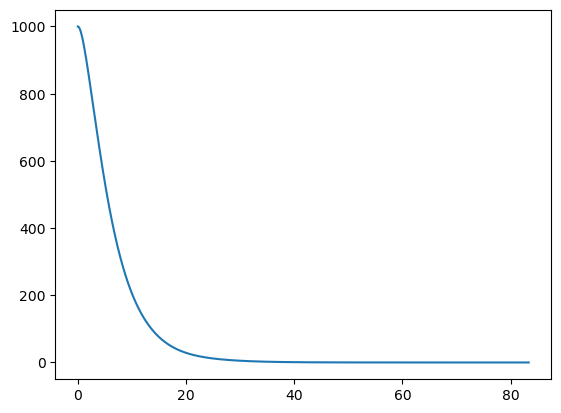

In [56]:
# Integración con euler
control_offset = [vals[g] / (2*np.cos(vals[a])/vals[m])]*2

args = [eom.state()] + [eom.input]
eom_np = lambdify(args, flatten(Matrix(eom.eqs).subs(vals)), modules="numpy")
def fun(t, y):
	u = np.sum(-K.gain_matrix*y, axis=1) + control_offset
	return np.array(eom_np(y, u))

timestep = 1/60
y = np.array([1000, 1000, 0, 0, 0, 0])
ys = [np.array(y)]
ts = [0]
for i in range(5000):
	t = (i+1) * timestep
	ts.append(t)
	y = y + fun(t, y) * timestep
	ys = np.vstack((ys, y))

plt.plot(ts, ys[:,1])